In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pygad
import logging
import random
from collections import Counter
import seaborn as sns
import scipy
import tqdm
from numba import jit
import multiprocess as mp
from functools import partial

In [5]:
arr = pd.read_csv("../data/phylo.csv",
                 delimiter=",")
display(arr)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,1,1,at1g01040.2,2173.635205,1911.200145,1152.555283,1291.422445,1000.252931,962.977223,1696.427421
1,2,1,at1g01050.1,1501.014084,1817.308557,1665.308874,1564.761244,1496.320663,1114.643547,1071.655487
2,3,1,at1g01070.1,1212.792724,1233.002267,939.200046,929.619501,864.218009,877.206001,894.818917
3,4,1,at1g01080.2,1016.920321,936.383717,1181.338144,1329.473434,1392.642854,1287.974590,861.260488
4,5,1,at1g01090.1,11424.566680,16778.168460,34366.649350,39775.640530,56231.568920,66980.367330,7772.561656
...,...,...,...,...,...,...,...,...,...,...
25255,25256,12,at5g67200.1,721.139701,731.211686,788.833156,815.185775,871.509726,809.404700,749.102579
25256,25257,12,at5g67245.1,1132.810160,1145.611552,1030.842523,1142.514730,1175.351616,985.904374,1147.261206
25257,25258,12,at5g67280.1,731.678348,748.688731,705.033813,622.710117,730.698691,864.307779,774.050852
25258,25259,12,at5g67380.1,14725.097780,2426.968469,2463.236828,2395.512964,1847.669032,1943.984418,5137.928045


In [6]:
ex_data = arr[["Zygote", "Quadrant","Globular","Heart","Torpedo","Bent","Mature"]]
ex_data_n = ex_data.to_numpy()

In [7]:
var_ex = ex_data.var(axis=1)/ex_data.mean(axis=1) 
age_weighted = ex_data.mul(arr["Phylostratum"], axis=0).to_numpy()
perc = 1
high_var_ind =  np.argsort(var_ex)[-round(len(var_ex) * perc):]
low_var_ind =  np.argsort(var_ex)[:-round(len(var_ex) * perc)]


In [8]:
high_var_w = age_weighted.iloc[high_var_ind,:]
high_var = ex_data.iloc[high_var_ind,:]
low_var_w = age_weighted.iloc[low_var_ind,:]
low_var = ex_data.iloc[low_var_ind,:]

high_var_w_n = high_var_w.to_numpy()
high_var_n = high_var.to_numpy()
low_var_w_sum = low_var_w.sum(axis=0).to_numpy()
low_var_sum = low_var.sum(axis=0).to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [9]:
def get_removed_genes_from_solution(solution):
    return arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]


In [11]:
def quantilerank(xs):
    ranks = scipy.stats.rankdata(xs, method='average')
    quantile_ranks = [scipy.stats.percentileofscore(ranks, rank, kind='weak') for rank in ranks]
    return np.array(quantile_ranks)

In [ ]:
def flat_line_test_g_dist(expres_data,rounds):
    ex = expres_data.copy()
    ex_ex = ex.iloc[:, 3:]
    phil = ex['Phylostratum']
    phil = quantilerank(phil)
    variances = []
    for _ in tqdm.trange(rounds):
        perm = np.random.permutation(phil)
        weighted = ex_ex.mul(perm, axis=0)
        avg = weighted.sum(axis=0)/ex_ex.sum(axis=0)
        variances.append(np.var(avg))
    shape, loc, scale = scipy.stats.gamma.fit(variances)
    print(shape)
    print(scale)
    print(loc)
    return scipy.stats.gamma(shape, scale=scale,loc=loc)




In [12]:
ex =arr.copy()
ex_ex = ex.iloc[:, 3:]
ex_ex = np.log(ex_ex).apply(lambda x: (x - x.mean()) / x.std(), axis=1)
phil = ex['Phylostratum']
phil = quantilerank(phil)
variances = []
for _ in tqdm.trange(40000):
    perm = np.random.permutation(phil)
    weighted = ex_ex.mul(perm, axis=0)
    avg = weighted.sum(axis=0)/ex_ex.sum(axis=0)
    variances.append(np.var(avg))

100%|██████████| 40000/40000 [03:30<00:00, 190.45it/s]


In [13]:
varrrs = pd.DataFrame(variances,columns=["vars"])

<Axes: ylabel='Count'>

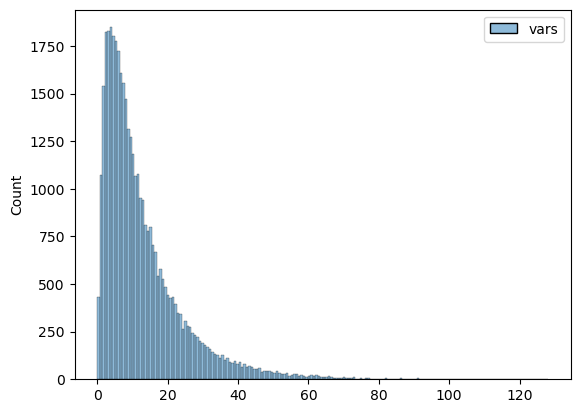

In [17]:
sns.histplot(varrrs)

In [242]:
gamma = flat_line_test_g_dist(arr,100000)

100%|██████████| 100000/100000 [05:49<00:00, 286.22it/s]


0.12422732547668659
1.7094504791289618


In [18]:
shape, scale, loc = scipy.stats.gamma.fit(variances)
_, p_value = scipy.stats.kstest(variances, 'gamma', args=(shape,))

In [22]:
scale

9.087965245120383

In [35]:
shape, loc, scale = scipy.stats.gamma.fit(variances)
gamma = scipy.stats.gamma(shape, scale=100,loc=loc)

In [276]:
gamma.pdf(0.00000255)

172678.8828685424

In [45]:
1 - np.array(gamma.cdf(17.6))

0.29186674383664113

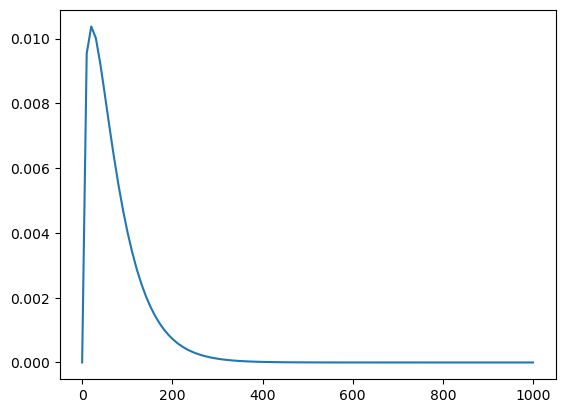

In [34]:
x = np.linspace (0, 1000, 100) 

#calculate pdf of Gamma distribution for each x-value
y = gamma.pdf(x)

#create plot of Gamma distribution
plt.plot(x, y)
#counts, bins = np.histogram(variances,density=True,bins=40)
#plt.stairs(counts, bins)
#display plot
plt.show()

In [44]:
def mutate2(mut_prob,offspring):
    if random.random() < mut_prob:
        randomlist = np.random.randint(0,len(offspring), size=random.randint(1,15))
        randomlist1 = np.random.randint(0,len(offspring), size=random.randint(1,10))
        for ind in randomlist:
            offspring[ind] = (offspring[ind] + 1) % 2
        offspring[randomlist1] = 0
    if len(offspring) - sum(offspring) < max_removed:
        return offspring
    zeros = np.random.permutation(np.where(offspring==0)[0])[:round(max_removed*0.9)]
    offspring = np.ones_like(offspring)
    offspring[zeros] = 0
    return offspring

def mutation_func2(offspring, ga_instance):
    mut = partial(mutate2, ga_instance.mutation_probability)

    # create and configure the process pool
    with mp.Pool() as pool2:
        # execute tasks in order
        res = pool2.map(mut, offspring)
        return np.array(res)

In [11]:
mutation_func2([np.ones(arr.shape[0]),np.zeros(arr.shape[0])],None)

AttributeError: 'NoneType' object has no attribute 'mutation_probability'

In [12]:
pool = mp.Pool(mp.cpu_count())
def compute_fitness(solution):
    up = solution.dot(age_weighted)
    down = solution.dot(ex_data_n)
    avgs = np.divide(up,down)
    num_not_removed = np.sum(solution,axis = 1)
    num_removed = solution.shape[1] - num_not_removed
    fitt = (1 - np.array(gamma.cdf(np.var(avgs,axis=1))) + (num_not_removed/solution.shape[1])) * np.multiply(num_removed < max_removed,1)
    return fitt

def fitness_batch(ga_instance, solution, solution_idx):
    sols = np.array_split(solution, mp.cpu_count())
    fitt = np.concatenate(pool.map(compute_fitness,sols))
    return fitt     
    

In [287]:
def fitness(ga_instance, solution, solution_idx):
    up = solution.dot(age_weighted)
    down = solution.dot(ex_data_n)
    avgs = np.divide(up,down)
    num_not_removed = np.sum(solution,axis = 1)
    num_removed = solution.shape[1] - num_not_removed
    fitt = (1 - np.array(gamma.cdf(np.var(avgs,axis=1)))) * np.multiply(num_removed < max_removed,1)
    return fitt


In [89]:
def tai_var(solution):
    up = solution.dot(age_weighted)
    down = solution.dot(ex_data_n)
    avgs = np.divide(up,down)
    return np.var(avgs)

In [312]:
def p_value_test(solution):
    return  1 - np.array(gamma.cdf(tai_var(solution)))
    

In [121]:
1 - np.array(gamma.cdf(0.13805062479925795))

0.192594556818371

In [120]:
gamma.mean()

0.13805062479925795

In [69]:
def var_batch(solution):
    up = solution.dot(age_weighted)
    down = solution.dot(ex_data_n)
    avgs = np.divide(up,down)
    return np.var(avgs,axis=1)

In [15]:
def get_ex_hist(removed_genes):
    variances = removed_genes.iloc[:, 2:].var(axis=1)
    variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})
    sns.histplot(data=variances_df,x="removed",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=30,label="removed")
    sns.histplot(data=variances_df,x="all",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=30,label="all")
    plt.legend()

In [49]:
def print_curve(solution,label=None):
    up = solution.dot(age_weighted)
    down = solution.dot(ex_data_n)
    avgs = np.divide(up,down)
    print(np.var(avgs))
    plt.ylim(3, 3.8)
    plt.plot(list(range(7)),avgs,'-o',label=label)
    if label:
        plt.legend()
    

In [17]:
def get_sol_from_indices(indices):
    ones = np.ones_like(solution)
    ones[indices] = 0
    return ones

In [318]:
def create_population(size,init_num_removed):
    return np.array([random.choices([0,1], weights=(1, random.randint(arr.shape[0]//(init_num_removed*3),arr.shape[0]//init_num_removed)), k=arr.shape[0]) for _  in range(size)])

0.009837646583158657


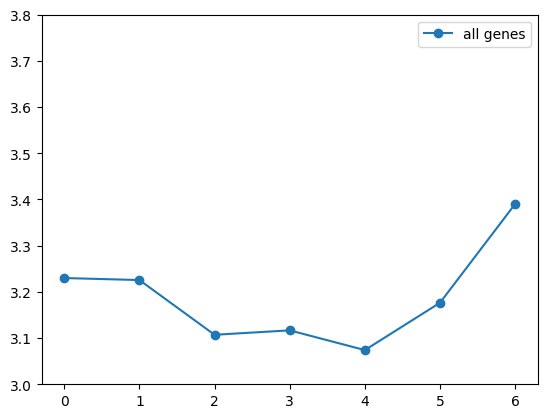

In [19]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [20]:
solution = None

In [21]:
def mutate(mut_prob,offspring):
    for chromosome_idx in range(offspring.shape[0]):
        if random.random() < mut_prob:
            randomlist = np.random.randint(0,offspring.shape[1], size=random.randint(1,15))
            randomlist1 = np.random.randint(0,offspring.shape[1], size=random.randint(1,10))
            for ind in randomlist:
                offspring[chromosome_idx][ind] = (offspring[chromosome_idx][ind] + 1) % 2
            offspring[chromosome_idx][randomlist1] = 0
            if offspring.shape[1] - sum(offspring[chromosome_idx]) > max_removed:
                zeros = np.random.permutation(np.where(offspring==0)[0])[:round(max_removed*0.9)]
                offs = np.ones_like(offspring[chromosome_idx])
                offs[zeros] = 0
                offspring[chromosome_idx] = offs
    return offspring

def mutation_func(offspring, ga_instance):
    offs = np.array_split(offspring, mp.cpu_count())
    mut = partial(mutate, ga_instance.mutation_probability)
    offspring = np.concatenate(pool.map(mut,offs))

    return offspring


In [190]:
def on_gen(ga_instance):
    if ga_instance.generations_completed % 5 == 1:
        print("Generation : ", ga_instance.generations_completed)
        print("Fitness of the best solution :", ga_instance.best_solution()[1])
        print("Variance of the best solution :", tai_var(ga_instance.best_solution()[0]))
        #print("P-value of the best solution :", p_value_test(ga_instance.best_solution()[0]))
        print("Length of the best solution :", len(ga_instance.best_solution()[0]) - sum(ga_instance.best_solution()[0]))
        


In [24]:
def crossover_funct(parents, offspring_size,ga_instance):
    offspring = np.empty(offspring_size)
    for i in range(offspring_size[0]//2):
        indices = np.random.choice(range(len(parents)), size=2)
        if ga_instance.crossover_probability > np.random.random():
           offspring[2*i] = parents[indices[0]]
           offspring[2*i+1] = parents[indices[1]]
        else:
            gene_sources = np.random.randint(0, 2, size=ga_instance.num_genes)
            swaps = np.random.choice(range(len(parents)), size=ga_instance.num_genes * 0.05,replace=False)
            offspring[2*i] = np.where(swaps, parents[indices[0]], parents[indices[1]])
            offspring[2*i+1] = np.where(gene_sources == 0, parents[indices[1]], parents[indices[0]])
    if offspring_size[0] % 2 == 1:
        offspring[-1,:] = parents[np.random.choice(range(len(parents)))]
    return offspring

In [36]:
def no_crossover(parents, offspring_size,ga_instance):
    chosen = np.random.randint(0,len(parents),size=offspring_size[0])
    return parents[chosen]


In [25]:

def scattered_crossover_cus(parents, offspring_size,ga_instance):

    """
    Applies the scattered crossover. It randomly selects the gene from one of the 2 parents. 
    It accepts 2 parameters:
        -parents: The parents to mate for producing the offspring.
        -offspring_size: The size of the offspring to produce.
    It returns an array the produced offspring.
    """

    offspring = np.empty(offspring_size, dtype=object)

    for k in range(offspring_size[0]):
        if not (ga_instance.crossover_probability is None):
            probs = np.random.random(size=parents.shape[0])
            indices = np.where(probs <= ga_instance.crossover_probability)[0]

            # If no parent satisfied the probability, no crossover is applied and a parent is selected.
            if len(indices) == 0:
                offspring[k, :] = parents[k % parents.shape[0], :]
                continue
            elif len(indices) == 1:
                parent1_idx = indices[0]
                parent2_idx = parent1_idx
            else:
                indices = random.sample(list(set(indices)), 2)
                parent1_idx = indices[0]
                parent2_idx = indices[1]
        else:
            # Index of the first parent to mate.
            parent1_idx = k % parents.shape[0]
            # Index of the second parent to mate.
            parent2_idx = (k+1) % parents.shape[0]

        # A 0/1 vector where 0 means the gene is taken from the first parent and 1 means the gene is taken from the second parent.
        gene_sources = np.random.randint(0, 4, size=ga_instance.num_genes)
        offspring[k, :] =  np.where(gene_sources > 0, parents[parent1_idx, :], parents[parent2_idx, :])

    return offspring

In [302]:
"""
level = logging.DEBUG
name = 'logfile.txt'

logger = logging.getLogger(name)
logger.setLevel(level)


console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_format = logging.Formatter('%(message)s')
console_handler.setFormatter(console_format)
logger.addHandler(console_handler)
"""
def run_GA():
    #prev_solution = solution
    num_threads = 4
    pop_size = 2500
    population = create_population(pop_size,3)

    ga_instance = pygad.GA(num_generations=130,
                        num_parents_mating=round(pop_size * 0.15),
                        fitness_func=fitness,
                        fitness_batch_size=population.shape[0],
                        initial_population=population,
                        on_generation=on_gen,
                        mutation_type=mutation_func2,
                        #crossover_type=crossover_funct,
                        crossover_probability=0.2,
                        mutation_probability=0.55,
                        init_range_low=0,
                        init_range_high=2,
                        gene_type=int,
                        
                        crossover_type="scattered",
                        parallel_processing=["thread", num_threads],
                        save_best_solutions=True,
                        keep_elitism=1
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    return ga_instance

In [317]:
max_removed = 200
solls = []
for _ in range(3):
    solls.append(run_GA())


/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


Generation :  1
Fitness of the best solution : 0.4470635938647334
Variance of the best solution : 0.009011928179502028
Length of the best solution : 22
Generation :  6
Fitness of the best solution : 0.4763968187332628
Variance of the best solution : 0.00580227018217695
Length of the best solution : 109
Generation :  11
Fitness of the best solution : 0.5110221729092617
Variance of the best solution : 0.0033419081573638075
Length of the best solution : 145
Generation :  16
Fitness of the best solution : 0.5416593828497499
Variance of the best solution : 0.0019847301663569873
Length of the best solution : 193
Generation :  21
Fitness of the best solution : 0.5712428399454276
Variance of the best solution : 0.0011604856682185878
Length of the best solution : 191
Generation :  26
Fitness of the best solution : 0.601336809184599
Variance of the best solution : 0.0006469048374060415
Length of the best solution : 189
Generation :  31
Fitness of the best solution : 0.6273580316646133
Variance o

In [304]:
solutions = []
for x in [200,170,140]:
    max_removed = x
    for i in range():
        solutions.append(run_GA())
    


/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


Generation :  1
Fitness of the best solution : 0.44901763122887106
Variance of the best solution : 0.008757647209621296
Length of the best solution : 55
Generation :  6
Fitness of the best solution : 0.47908082033028776
Variance of the best solution : 0.00556654915231472
Length of the best solution : 93
Generation :  11
Fitness of the best solution : 0.5051819398386673
Variance of the best solution : 0.0036774666157919364
Length of the best solution : 121
Generation :  16
Fitness of the best solution : 0.538825651095003
Variance of the best solution : 0.0020856711276996984
Length of the best solution : 181
Generation :  21
Fitness of the best solution : 0.5659306101431877
Variance of the best solution : 0.001281234528979854
Length of the best solution : 193
Generation :  26
Fitness of the best solution : 0.5928708854538074
Variance of the best solution : 0.0007657252678339963
Length of the best solution : 198
Generation :  31
Fitness of the best solution : 0.6211064104323569
Variance o

In [65]:
sols = np.array([ga_instance.best_solutions[0] for ga_instance in solutions])

0.009293125180756647


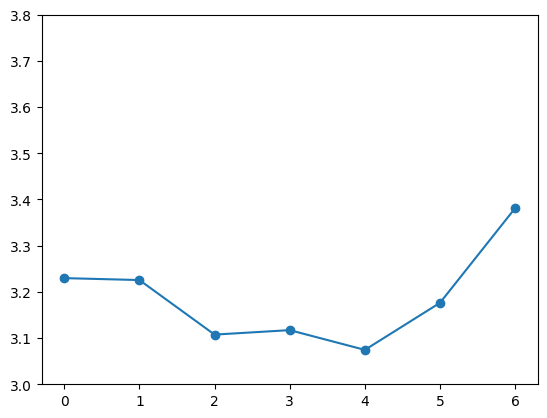

In [73]:
print_curve(sols[2])

In [ ]:
max_removed = 250
ga_instance = run_GA()

In [286]:
soll = ga_instance

In [756]:
prev_ga = ga_instance

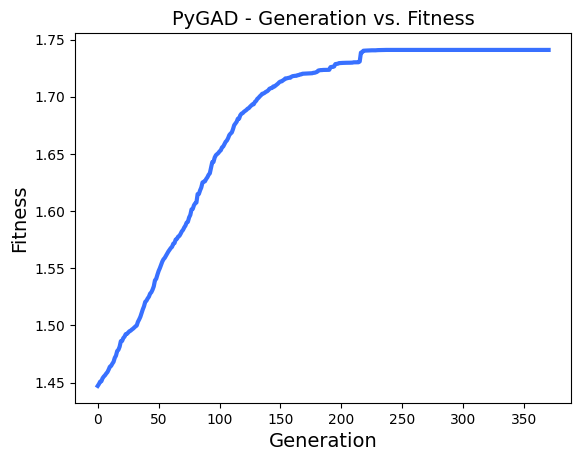

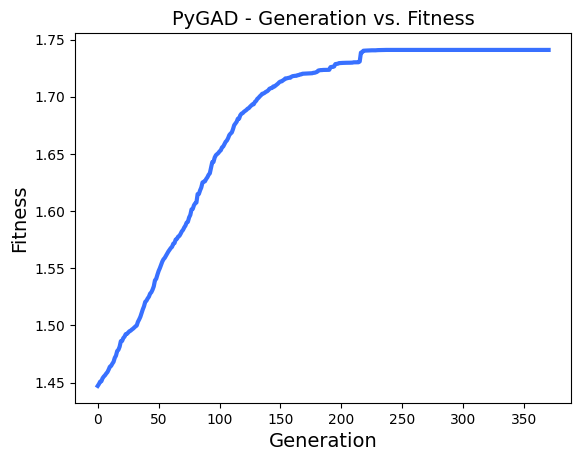

In [651]:
solutions[0].plot_fitness()

In [763]:
solutions = []
for i in range(3):
    solutions.append(run_GA())

/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


In [764]:
solution2s = []
for i in range(6):
    solution2s.append(run_GA())

In [765]:
sols = np.array([x.best_solution()[0] for x in solutions])

In [769]:
sols2 = np.array([x.best_solution()[0] for x in solution2s])

In [766]:
var_batch(sols)

array([1.16519340e-05, 1.34716639e-05, 6.43884954e-06])

In [772]:
for sol in sols2:
    sols = np.vstack([sols, sol])

In [773]:
sols.shape

(9, 25260)

1.4611347188422325e-05


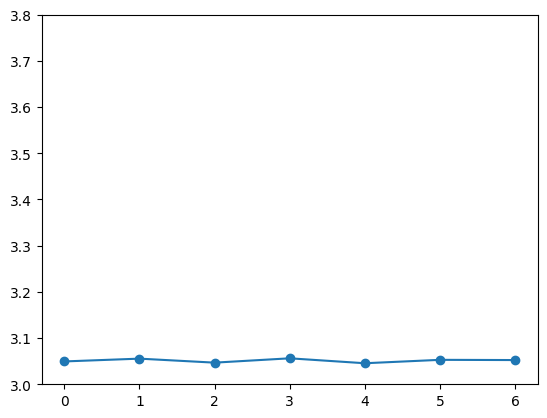

In [315]:
print_curve(solutions[2].best_solution()[0])

In [592]:
len(np.where(solution == 0)[0])

999

In [52]:
len(np.where(ga_instance.best_solution()[0] == 0)[0])

149

In [316]:
com_rem_arr = np.logical_or(solutions[3].best_solution()[0] == 1, solutions[2].best_solution()[0] == 1)

KeyboardInterrupt: 

In [300]:
com_rem_arr

array([ True,  True,  True, ...,  True,  True, False])

0.00033871457584160297


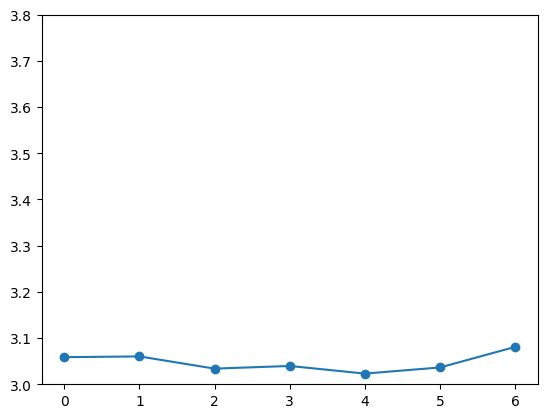

In [ ]:
print_curve(com_rem_arr)

In [224]:
stats = solutions[0][1]

In [219]:
solutions = np.array(solutions)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/1415263720.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  solutions = np.array(solutions)


0.00041707006058392965


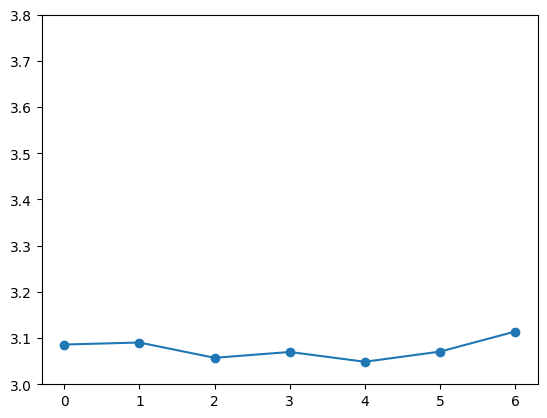

In [761]:
common_removed = arr.iloc[high_var.index.values[np.logical_and(ga_instance.best_solution()[0] == 0, prev_ga.best_solution()[0] == 0)],:]
com_rem_arr = np.logical_or(ga_instance.best_solution()[0] == 1, prev_ga.best_solution()[0] == 1)
print_curve(com_rem_arr)

138
1.639108609841805e-05


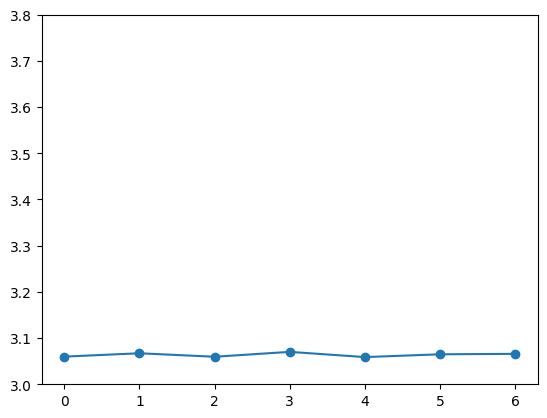

In [788]:
mul_targ = np.where((sols.shape[0] -  sols.sum(axis=0)) > 4)[0]
print(len(mul_targ))
mul_targ = get_sol_from_indices(mul_targ)
removed_mul_targ = get_removed_genes_from_solution(mul_targ)
print_curve(mul_targ)

In [678]:
num_of_removed = sols.shape[1] -  sols.sum(axis=1)
num_of_removed

array([504, 504])

In [548]:
np.array(sols).shape[1] - np.array(sols).sum(axis=1)

array([590, 593])

In [ ]:
sols = []

In [774]:
common = set.intersection(*map(set,(np.where(solution == 0)[0] for solution in sols)))
len(common)

38

0.0024884024202718896


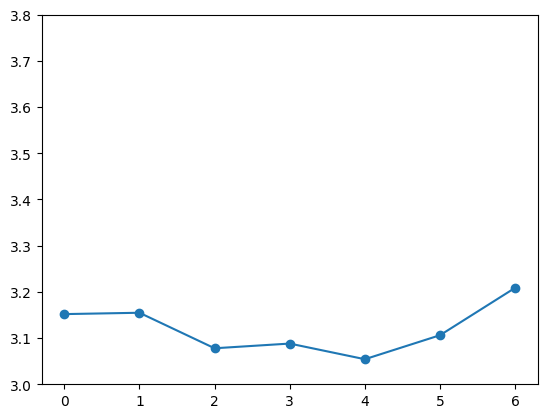

In [775]:
print_curve(get_sol_from_indices(list(common)))

5.1082210666394055e-05
377
0.014924782264449724


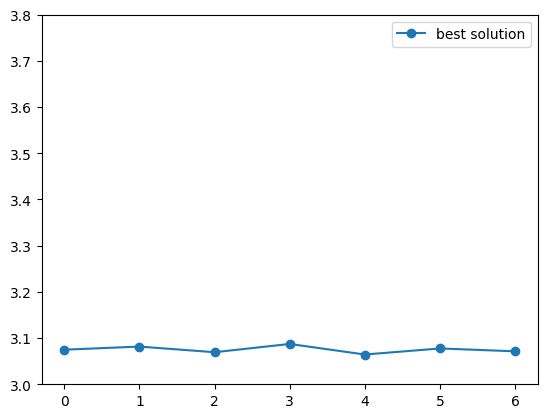

In [181]:
print_curve(solutions[2],label="best solution")
print(len(np.where(solution == 0)[0]))
print(len(np.where(solution == 0)[0])/len(solution))


In [57]:
# in how many generations new best fitness emerged
print(len(set(ga_instance.best_solutions_fitness)))

161


In [138]:
len(ga_instance.best_solutions_fitness)

181

In [272]:

lens = len(solution) - np.sum(np.array(ga_instance.solutions),axis = 1)
fit =fitness_batch(None,np.array(ga_instance.solutions),None)
fit_ind = np.argsort(fitness_batch(None,np.array(ga_instance.solutions),None))
plt.scatter(lens,fit, s=0.1)

AxisError: axis 1 is out of bounds for array of dimension 1

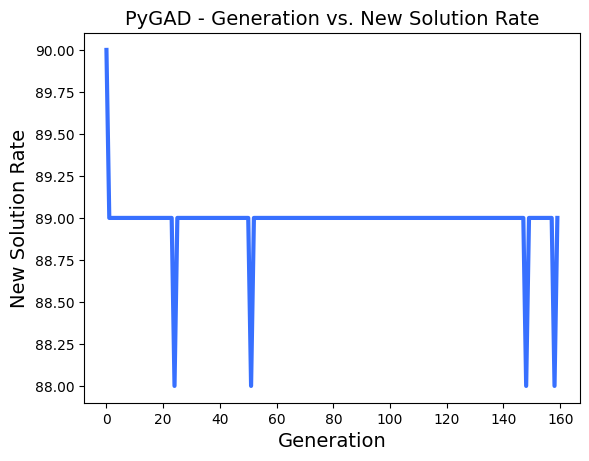

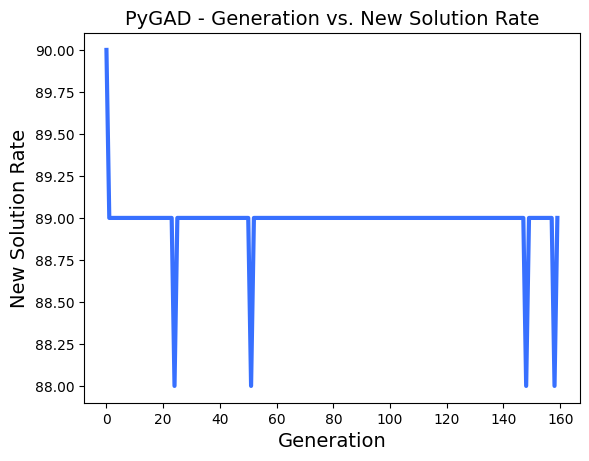

In [191]:
ga_instance.plot_new_solution_rate()

0.009837646583158657


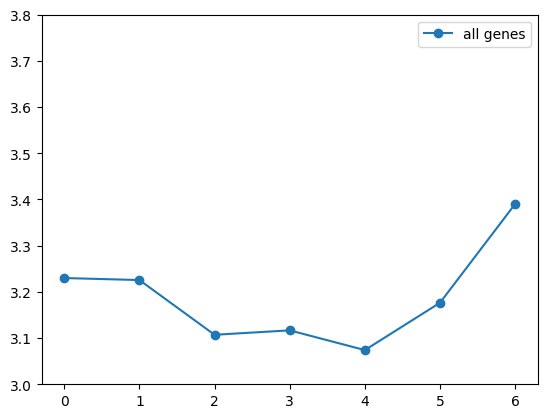

In [532]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [140]:
comm = get_removed_genes_from_solution(ones)

In [42]:
removed_genes =  arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]

display(removed_genes)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/2635158219.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = removed_genes.iloc[:, 2:].var(axis=1)


,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
8097,8098,1,at5g40020.1,685.724723,680.611796,671.045301,681.262277,705.428063,658.706627,685.322192
4800,4801,1,at3g26780.1,661.913185,698.076319,682.836045,668.451217,672.081580,654.825536,680.219241
6634,6635,1,at4g32170.1,741.239790,755.183286,726.176003,765.633587,773.604256,746.520416,757.320410
25056,25057,12,at5g38240.1,621.815292,609.621129,598.470127,637.846169,617.250087,608.082312,596.378559
8903,8904,1,at5g61910.4,748.406405,742.488793,734.041345,737.110101,738.559992,724.769498,697.309005
...,...,...,...,...,...,...,...,...,...,...
21826,21827,8,at2g42560.1,2457.993370,835.481543,834.124473,760.883619,726.684578,3752.426116,68490.545990
23539,23540,12,at1g07500.1,2236.167648,872.144043,816.071814,852.034298,824.409176,1904.961405,67841.771130
21446,21447,7,at1g07985.1,2962.440546,904.682744,899.162118,814.911574,784.399822,2371.147397,71635.640930
20234,20235,6,at1g75830.1,4458.236715,998.800310,986.139617,933.795325,814.189089,1335.810446,72600.065370


<AxesSubplot: xlabel='Phylostratum', ylabel='Count'>

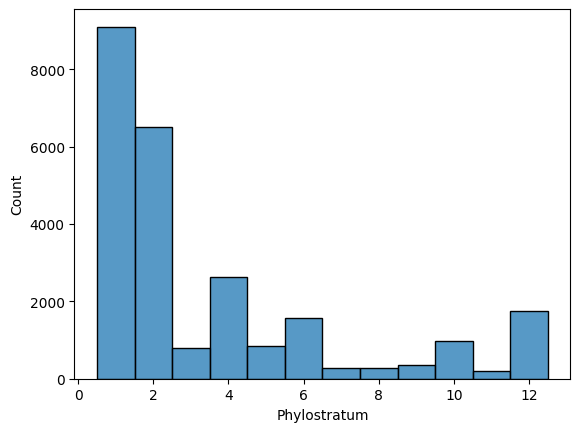

In [43]:
sns.histplot(data=arr,x="Phylostratum",discrete=True)

<BarContainer object of 12 artists>

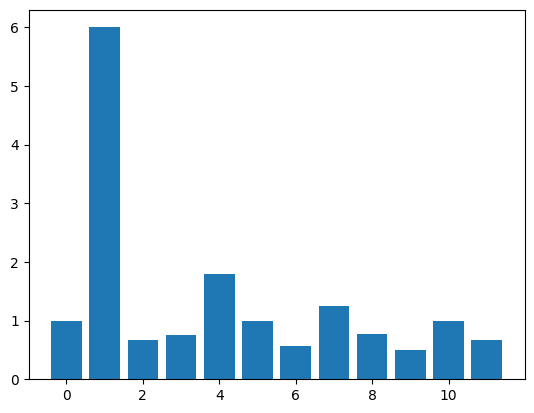

In [44]:
dff = np.array(list(Counter(removed_genes["Phylostratum"])))/np.array(list(Counter(arr["Phylostratum"])))
plt.bar(range(len(dff)),dff)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/1673284101.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = removed_genes.iloc[:, 2:].var(axis=1)
/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/1673284101.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})


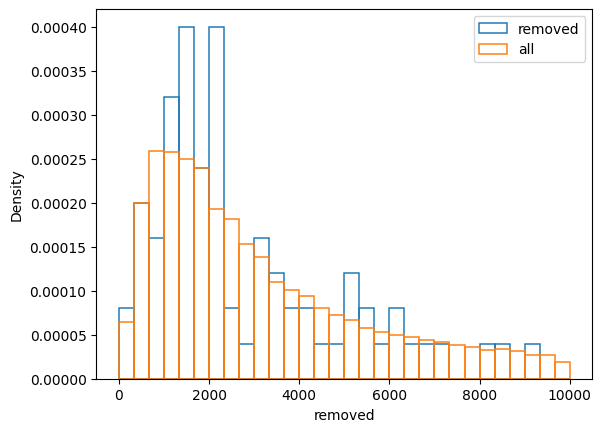

In [187]:
get_ex_hist(get_removed_genes_from_solution(solutions[1]))

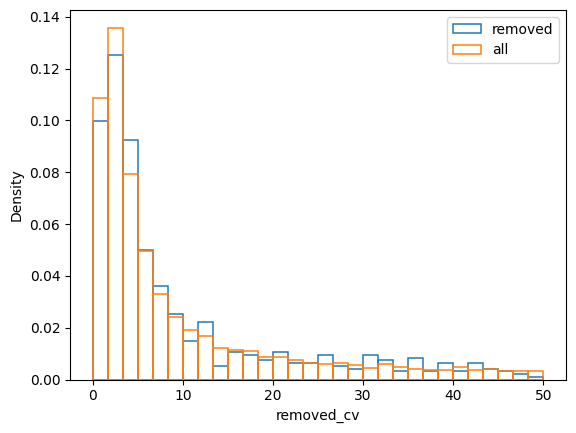

In [278]:
sns.histplot(data=variances_df,x="removed_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="removed")
sns.histplot(data=variances_df,x="all_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="all")
plt.legend()


In [682]:
25260/50

505.2

In [681]:
arr.shape

(25260, 10)

In [701]:
inds = [[np.array(random.sample(range(arr.shape[0]),50*x)) for _ in range(10)] for x in range(1,arr.shape[0]//50)]

In [697]:
inds[0]

[[7794,
  8164,
  15445,
  20368,
  16366,
  13865,
  13476,
  8008,
  1082,
  5326,
  9337,
  21548,
  22718,
  11841,
  13403,
  14413,
  3743,
  1739,
  17890,
  18945,
  101,
  21781,
  3344,
  13502,
  24112,
  13522,
  23343,
  16455,
  13953,
  16966,
  13391,
  7383,
  19656,
  7169,
  7738,
  7511,
  12147,
  12186,
  23521,
  17792,
  1919,
  12966,
  14245,
  5529,
  20198,
  4894,
  9004,
  15584,
  19907,
  11229],
 [19875,
  16832,
  11724,
  24115,
  19640,
  19182,
  8843,
  758,
  15879,
  14040,
  23252,
  1002,
  1391,
  4388,
  637,
  9860,
  3331,
  19476,
  15965,
  4481,
  14061,
  10432,
  15924,
  6813,
  1502,
  16810,
  4685,
  15229,
  13764,
  17789,
  57,
  11723,
  17145,
  867,
  14550,
  11738,
  22953,
  8408,
  7049,
  18643,
  13754,
  21668,
  17671,
  22336,
  4048,
  16017,
  22774,
  10083,
  20485,
  20112],
 [1330,
  14783,
  9543,
  13027,
  12551,
  24131,
  4589,
  9314,
  3397,
  11710,
  21217,
  16226,
  14007,
  809,
  19831,
  4682,
  1

In [709]:
variances = []
for indd in inds:
    for ind in indd:
        get_sol_from_indices(ind)
    sols = list(map(get_sol_from_indices,indd))
    variances.append(np.mean(var_batch(np.array(sols))))


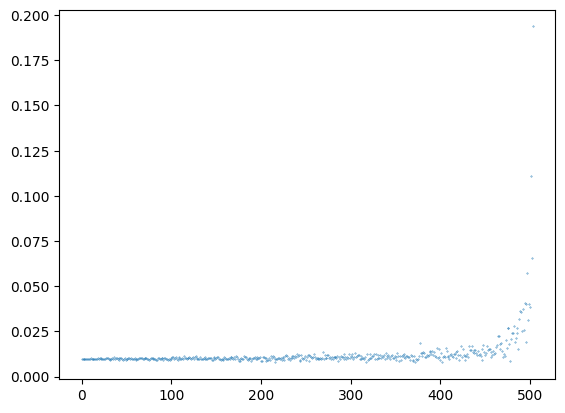

In [714]:
plt.scatter(range(len(variances)),variances,s=0.1)